# Homework 5 
## Part 1


### Task 1 [20 points] 
#### Using the starter code and dataset (the data dictionary is also available) provided in this repo to predict whether an employee will leave their current position at the end of the time period or not (i.e., for your model, make sure to set Leave as the True label), implement the following models with a common pipeline and perform basic model tuning

* Logistic regression
* Random forest
* Gradient boosting model


### Task 2 [10 points] 
#### Calculate the financial value of your models based on the following costs and benefits

* Again, Leave being the True class and Stay being False
* Cost of replacing an employee is \$120,000 (RC)
* Cost of intervention $2,000 used on each employee predicted to leave (IC)
* Intervention success rate is 20% (SR)

| |Actual Leave|Actual Stay|
|---|---|---|
|Predicted Leave|TP|FP|
|Predicted Stay|FN|TN|
* Compare models on value, what is the best model according to your value metric?

# **Machine Learning using scikit-learn**

As a reminder, below are the following best practices we should follow when performing Machine Learning in Python:

1. Perform all pre-processing steps within cross-validation
2. Measure model performance (and model selection) using cross-validation
3. Follow literate programming practices to make code readable and make collaboration easier

## Problem Formulation

In this example, we will use IBM's HR Attrition dataset, available here: https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset.
The dataset contains data on 1470 employees. The variables covered in this dataset focus heavily on demographic attributes (e.g. gender, age and race), social related attributes (e.g. marital status) and work related attributes (e.g. tenure and pay).

In [138]:
#tables and visualizations
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#machine learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, StandardScaler
from sklearn import config_context
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

## Load Data

Here we first load the data into python using pandas and read it in as a pandas dataframe which is the format which we will use throughout the example. 

In [139]:
employee_df = pd.read_excel('https://github.com/vanderbilt-ml/50-assign05-austinjhunt/raw/main/IBM-HR-Data-Employee-Attrition.xlsx')
display(employee_df.head())
employee_df.info()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

## Data cleaning and EDA

We can now briefly explore our data. For now, we can observe that there are a zero NA values which will likely need imputation. We'll wait for this step so that we can put it within our training loop in case future data sets from IBM HR might have NA values. You are welcome to explore additional aspects of the data and build out 2-3 features on your own

In [140]:
employee_df.isna().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

Great! None of our columns have missing values. No imputation required. 

There are certain fields that look like they're not going to be helpful. 

In [141]:
employee_df.nunique()

Age                           43
Attrition                      2
BusinessTravel                 3
DailyRate                    886
Department                     3
DistanceFromHome              29
Education                      5
EducationField                 6
EmployeeCount                  1
EmployeeNumber              1470
EnvironmentSatisfaction        4
Gender                         2
HourlyRate                    71
JobInvolvement                 4
JobLevel                       5
JobRole                        9
JobSatisfaction                4
MaritalStatus                  3
MonthlyIncome               1349
MonthlyRate                 1427
NumCompaniesWorked            10
Over18                         1
OverTime                       2
PercentSalaryHike             15
PerformanceRating              2
RelationshipSatisfaction       4
StandardHours                  1
StockOptionLevel               4
TotalWorkingYears             40
TrainingTimesLastYear          7
WorkLifeBa

EmployeeCount, Over18, and StandardHours each have only one unique value, so these are not going to be helpful. 

In [142]:
employee_df.drop(columns=['StandardHours', 'Over18', 'EmployeeCount'], inplace=True)


Also, EmployeeNumber is just an ID; that's not going to have any predictive value. 

In [143]:
employee_df.drop(columns=['EmployeeNumber'], inplace=True)

New shape!

In [144]:
employee_df = employee_df.dropna(subset=['Attrition'])
employee_df.shape


(1470, 31)

Let's check to see how balanced our classes are.

In [145]:
employee_df.groupby('Attrition')['Attrition'].count()

Attrition
No     1233
Yes     237
Name: Attrition, dtype: int64

Very imbalanced! Looks like a good signal to use stratified sampling during the cross validation phase.

In [146]:
class_column = 'Attrition'
random_seed = 2435

X_train, X_test, y_train, y_test = train_test_split(employee_df.drop(columns=class_column), employee_df[class_column],
                                                   test_size=0.25, random_state=random_seed, stratify=employee_df[class_column])

Quick sanity check to make sure that everything seems correct:

In [147]:
# X Train
print('On X train: ')
print('X train dimensions: ', X_train.shape)
display(X_train.head())

# X test
print('\nOn X test: ')
print('X test dimensions: ', X_test.shape)
display(X_test.head())

On X train: 
X train dimensions:  (1102, 30)


,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
1331,48,Travel_Rarely,1224,Research & Development,10,3,Life Sciences,4,Male,91,...,3,4,0,29,3,3,22,10,12,9
485,27,Travel_Rarely,798,Research & Development,6,4,Medical,1,Female,66,...,3,3,2,6,5,2,5,3,0,3
1368,34,Travel_Frequently,735,Research & Development,22,4,Other,3,Male,86,...,3,2,0,16,3,3,15,10,6,11
579,34,Travel_Rarely,121,Research & Development,2,4,Medical,3,Female,86,...,3,3,0,6,3,3,6,5,1,3
142,38,Travel_Rarely,364,Research & Development,3,5,Technical Degree,4,Female,32,...,4,2,0,19,2,3,3,2,2,2



On X test: 
X test dimensions:  (368, 30)


,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
129,49,Travel_Rarely,470,Research & Development,20,4,Medical,3,Female,96,...,3,3,0,16,2,2,15,11,5,11
1120,38,Travel_Rarely,437,Sales,16,3,Life Sciences,2,Female,90,...,3,2,0,8,5,4,3,2,1,2
3,33,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,56,...,3,3,0,8,3,3,8,7,3,0
965,25,Travel_Rarely,882,Research & Development,19,1,Medical,4,Male,67,...,3,3,3,7,6,2,3,2,1,2
94,32,Travel_Rarely,1093,Sales,6,4,Medical,2,Male,87,...,3,1,0,12,0,3,11,8,5,7


In [148]:
# X Train
print('On y train: ')
print('y train dimensions: ', y_train.shape)
display(y_train.head())

# X test
print('\nOn y test: ')
print('y test dimensions: ', y_test.shape)
display(y_test.head())

On y train: 
y train dimensions:  (1102,)


1331    No
485     No
1368    No
579     No
142     No
Name: Attrition, dtype: object


On y test: 
y test dimensions:  (368,)


129     No
1120    No
3       No
965     No
94      No
Name: Attrition, dtype: object

## Establish the training pipeline

We can now establish the training pipeline for our models. Since this is a process we would need to repeat several times, it's good to essentially functionalize the process so we do not need to re-write redundant code. Here, we can impute some values that were missing, and encode any categorical values. Note that these pipelines will change according to the model and methodology you choose - additionally, the pipelines will also change depending on the data types of the columns in your dataset. 

In [149]:
# TODO: establish your own pipelines for the different data types
# individual pipelines for differing datatypes
# impute missing values for categorical variables by replacing those missing ones with the most frequent value.
# current data set does not have missing values but this wont hurt, can only help in case future data does have missing values
# then use one hot encoding to encode the categorical variables. 
cat_pipeline = Pipeline(steps=[('cat_impute', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                               ('onehot_cat', OneHotEncoder(drop='if_binary'))])
# impute missing values for numerical variables by replacing them with the mean value for that variable
# current data set does not have missing values but this wont hurt, can only help in case future data does have missing values
# then standardize the features by removing the mean and scaling to unit variance.
num_pipeline = Pipeline(steps=[('impute_num', SimpleImputer(missing_values=np.nan, strategy='mean')),
                               ('scale_num', StandardScaler())])


In [150]:
# TODO: establish your preprocessing pipeline by your feature set

# establish preprocessing pipeline by columns
# use ColumnTransformer to apply categorical pipeline to categorical (i.e. object) features and 
# apply numerical pipeline to the numerical features. pass through the remaining features if any.
preproc = ColumnTransformer([('cat_pipe', cat_pipeline, make_column_selector(dtype_include=object)),
                             ('num_pipe', num_pipeline, make_column_selector(dtype_include=np.number))],
                             remainder='passthrough')



### Logistic Regression Classifier 
Logistic regression estimates the probability of an event occurring, such as voted or didn't vote, based on a given dataset of independent variables. Since the outcome is a probability, the dependent variable is bounded between 0 and 1.

In [151]:
# generate the whole modeling pipeline with preprocessing
# full pipeline should start with preprocessing sub pipeline and lead into 
# a logistic regression model. use elasticnet penalty to add both L1 and L2 penalty terms
# elasticnet only works with saga solver, which is the algorithm to use in the optimization problem
# use; saga is good for large datasets, and this dataset is large
model = LogisticRegression(penalty='elasticnet', solver='saga')
logisticregression_pipeline = Pipeline(steps=[('preproc', preproc),
                       ('mdl', model)])

# visualization of pipeline 
with config_context(display='diagram'):
    display(logisticregression_pipeline)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fee576e4f50>),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer()),
                                                                  ('scale_num',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fee576e4290>)])),
                ('mdl',
                 LogisticRegression(penalty='elasticnet', solver='saga'))])

### Random Forest Classifier
Random forests or random decision forests is an ensemble learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time. For classification tasks, the output of the random forest is the class selected by most trees.

In [152]:
model = RandomForestClassifier()
randomforest_pipeline = Pipeline(steps=[('preproc', preproc),
                       ('mdl', model)])

# visualization of pipeline 
with config_context(display='diagram'):
    display(randomforest_pipeline)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fee576e4f50>),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer()),
                                                                  ('scale_num',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fee576e4290>)])),
                ('mdl', RandomForestClassifier())])

### Gradient Boosting Classifier
Gradient boosting is a machine learning technique used in regression and classification tasks, among others. It gives a prediction model in the form of an ensemble of weak prediction models, which are typically decision trees. The main difference between random forests and gradient boosting lies in how the decision trees are created and aggregated. Unlike random forests, the decision trees in gradient boosting are built additively; in other words, each decision tree is built one after another.

In [153]:
model = GradientBoostingClassifier()
gradientboosting_pipeline = Pipeline(steps=[('preproc', preproc),
                       ('mdl', model)])

# visualization of pipeline 
with config_context(display='diagram'):
    display(gradientboosting_pipeline)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fee576e4f50>),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer()),
                                                                  ('scale_num',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fee576e4290>)])),
                ('mdl', GradientBoostingClassifier())])

## Cross-validation with hyperparameter tuning

Now that we have our pipelines, we can now use this as part of cross validation and hyperparameter tuning.

### Logistic Regression Classifier 

In [154]:
# create a tuning grid for the grid search cross validation algorithm to work on
# grid defines the set of parameter values we want to check during optimization

logisticregression_tuning_grid = {
    # For logistic regression, we can tune the L1 ratio; if l1_ratio = 1, the penalty would be L1 penalty. 
    # If l1_ratio = 0, the penalty would be an L2 penalty. If the value of l1 ratio is between 0 
    # and 1, the penalty would be the combination of L1 and L2. Let's test with 0, 0.25, 0.5, 0.75, and 1
    'mdl__l1_ratio' : np.linspace(0,1,5),
    # the C parameter represents the inverse of regularization strength; smaller C
    # means stronger regularization (where regularization penalizes overfitting)
    # must be a positive float, so let's try a very small value (stronger reg) and a large value 
    # (weaker reg)
    'mdl__C': np.logspace(-1, 6, 3) 
    }
# let's create our grid search object, pass in our pipeline and our tuning grid
# passing 5 to the CV argument to specify 5 folds in a (Stratified)KFold cross-validation splitting strategy.
# we established earlier that there is a strong imbalance between our two classes of Attrition (Yes & No), 
# stratified k-fold preserves the imbalanced class distribution in each fold. 
# it will enforce the class distribution in each split of the data to match the distribution in the complete training dataset.
logisticregression_grid_search = GridSearchCV(logisticregression_pipeline, 
                           param_grid = logisticregression_tuning_grid, 
                           cv = 5, 
                           return_train_score=True)



In [155]:
# TODO: fit your model
logisticregression_grid_search.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat_pipe',
                                                                         Pipeline(steps=[('cat_impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot_cat',
                                                                                          OneHotEncoder(drop='if_binary'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fee576e4f50>),
                                                                        ('num_pipe',
                                                    

In [156]:
# TODO: find the best performing model parameters and their values
print(logisticregression_grid_search.best_score_)
print(logisticregression_grid_search.best_estimator_)
print(logisticregression_grid_search.best_params_)


0.877490744549568
Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fee579d1790>),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer()),
                                                                  ('scale_num',
              

### Random Forest Classifier

In [157]:
# create a tuning grid for the grid search cross validation algorithm to work on
# grid defines the set of parameter values we want to check during optimization

randomforest_tuning_grid = {
    # number of trees in forest
    'mdl__n_estimators': np.linspace(10, 150, 10).astype(int),
    # The number of features to consider when looking for the best split, can be auto, sqrt, log2
    'mdl__max_features': ['auto', 'sqrt', 'log2'],
    # The maximum depth of the tree
    'mdl__max_depth' : np.linspace(5, 10, 1).astype(int),
    # The function to measure the quality of a split. This parameter is tree-specific.
    'mdl__criterion' :['gini', 'entropy']
}
# let's create our grid search object, pass in our pipeline and our tuning grid
# passing 5 to the CV argument to specify 5 folds in a (Stratified)KFold cross-validation splitting strategy.
# we established earlier that there is a strong imbalance between our two classes of Attrition (Yes & No), 
# stratified k-fold preserves the imbalanced class distribution in each fold. 
# it will enforce the class distribution in each split of the data to match the distribution in the complete training dataset.
randomforest_grid_search = GridSearchCV(randomforest_pipeline, 
                           param_grid = randomforest_tuning_grid, 
                           cv = 5, 
                           return_train_score=True)


In [158]:
# fit the model 
randomforest_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat_pipe',
                                                                         Pipeline(steps=[('cat_impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot_cat',
                                                                                          OneHotEncoder(drop='if_binary'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fee576e4f50>),
                                                                        ('num_pipe',
                                                    

### Gradient Boosting Classifier

In [166]:
# create a tuning grid for the grid search cross validation algorithm to work on
# grid defines the set of parameter values we want to check during optimization
gradientboosting_tuning_grid = {
    # Learning rate shrinks the contribution of each tree by learning_rate; default = 0.1
    'mdl__learning_rate': np.linspace(0.25, 1, 3),
    # The number of boosting stages to perform. Gradient boosting is fairly 
    # robust to over-fitting so a large number usually results in better 
    # performance. Values must be in the range [1, inf).
    'mdl__n_estimators': np.linspace(10, 100, 5).astype(int),
    # the maximum depth of the individual regression estimators
    'mdl__max_depth': np.linspace(5,10,3).astype(int),
    # The function to measure the quality of a split.
    'mdl__criterion' : ['friedman_mse', 'squared_error']
}
# let's create our grid search object, pass in our pipeline and our tuning grid
# passing 5 to the CV argument to specify 5 folds in a (Stratified)KFold cross-validation splitting strategy.
# we established earlier that there is a strong imbalance between our two classes of Attrition (Yes & No), 
# stratified k-fold preserves the imbalanced class distribution in each fold. 
# it will enforce the class distribution in each split of the data to match the distribution in the complete training dataset.
gradientboosting_grid_search = GridSearchCV(
                          gradientboosting_pipeline, 
                          param_grid = gradientboosting_tuning_grid, 
                          cv=5, 
                          return_train_score=True)


In [167]:
gradientboosting_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat_pipe',
                                                                         Pipeline(steps=[('cat_impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot_cat',
                                                                                          OneHotEncoder(drop='if_binary'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fee576e4f50>),
                                                                        ('num_pipe',
                                                    

## Final fit

The final fit here is already present in the generated model due to the way we set our parameters in the grid search. If we want to look at the performance, we can do so. Here is a non-helpful description of the best model:

### Logistic Regression Classifier

In [168]:
# TODO: print your best estimator (pipeline)
print(logisticregression_grid_search.best_estimator_)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fee579d1790>),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer()),
                                                                  ('scale_num',
                                

### Random Forest Classifier

In [169]:
print(randomforest_grid_search.best_estimator_)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fee575e6ed0>),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer()),
                                                                  ('scale_num',
                                

### Gradient Boosting Classifier

In [170]:
print(gradientboosting_grid_search.best_estimator_)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fee56710290>),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer()),
                                                                  ('scale_num',
                                

## Variable importance

Now we assess the importance in the selected model to reveal any potential insights.

### Logistic Regression Classifier

In [171]:
# TODO: feel free to print out the target classes
logisticregression_grid_search.classes_

array(['No', 'Yes'], dtype=object)

In [174]:
# TODO: feel free to uncomment and edit the code below to obtain your feature weights

vip = logisticregression_grid_search.best_estimator_['mdl'].coef_[0]
vip

array([-4.63907962e-01,  4.83822438e-01, -2.51637520e-02,  5.24244839e-02,
       -2.27016284e-01,  1.69342524e-01,  1.20388750e-01, -2.16524523e-01,
        1.06033061e-01, -1.21043759e-01, -2.03191713e-01,  3.09088908e-01,
        2.54845811e-01, -2.40008208e-01,  1.04447965e-01,  3.89468335e-01,
       -1.52835609e-02, -1.86584554e-01, -1.41160275e-01, -1.78084759e-01,
        2.22539599e-02,  2.39701819e-01, -2.30340657e-01, -2.07869316e-01,
        4.32960697e-01,  1.32550926e+00, -2.66183220e-01, -1.52084590e-01,
        2.90807353e-01,  3.06620646e-03, -3.06369702e-01, -7.78356091e-04,
       -3.07931785e-01, -2.80764219e-01, -3.43241084e-01, -1.58508091e-01,
       -1.47875494e-02,  3.26835016e-01, -3.66404873e-02, -3.16459213e-02,
       -1.89722504e-01, -1.43854948e-01, -9.49131464e-02, -2.15497927e-01,
       -2.76232610e-01,  2.82427828e-01, -3.83412694e-01,  4.99190183e-01,
       -4.82281417e-01])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


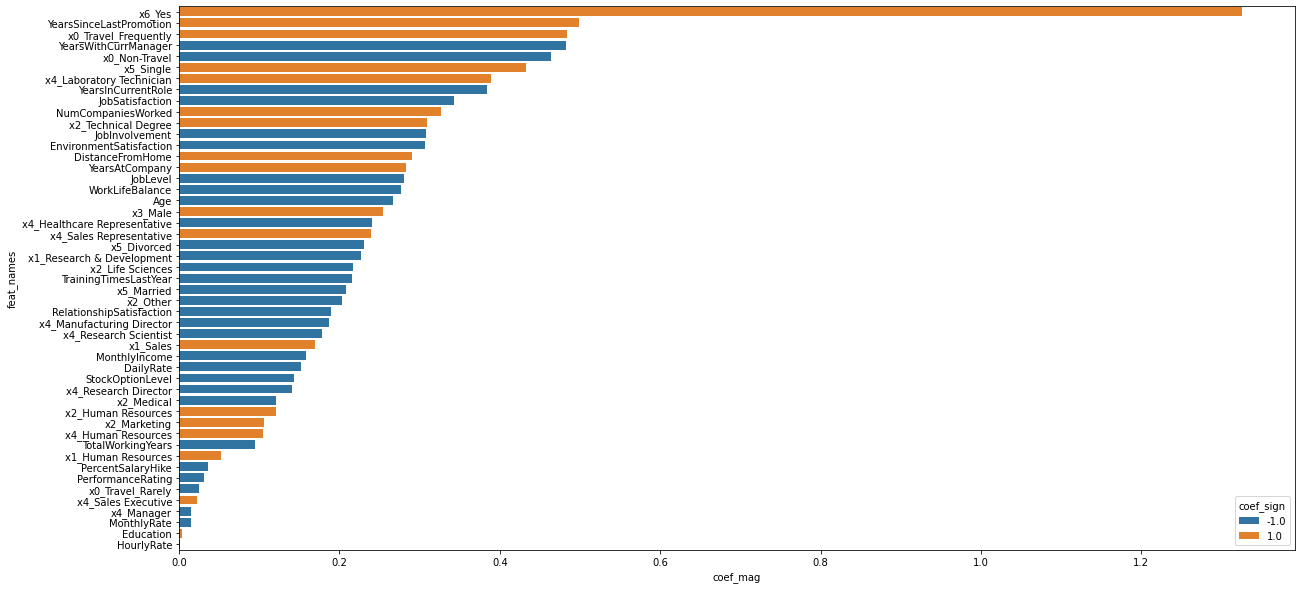

In [173]:
# TODO: feel free to uncomment and edit the code below to obtain your feature importance graph. 
# Did the graph surprise you? What features did you think were more important?

# get names in correct preproc order
cat_names = logisticregression_grid_search.best_estimator_.named_steps['preproc'].transformers_[0][1].named_steps['onehot_cat'].get_feature_names()
num_names = logisticregression_grid_search.best_estimator_.named_steps['preproc'].transformers_[1][2]

# create df with vip info
coef_info = pd.DataFrame({'feat_names':np.hstack([cat_names, num_names]), 'vip': vip})

# #get sign and magnitude information
coef_info = coef_info.assign(coef_mag = abs(coef_info['vip']),
                             coef_sign = np.sign(coef_info['vip']))

# #sort and plot
coef_info = coef_info.set_index('feat_names').sort_values(by='coef_mag', ascending=False)
plt.figure(figsize = (20,10))
sns.barplot(y=coef_info.index, x='coef_mag', hue='coef_sign', data=coef_info, orient='h', dodge=False)

### Random Forest Classifier

In [175]:
randomforest_grid_search.classes_

array(['No', 'Yes'], dtype=object)

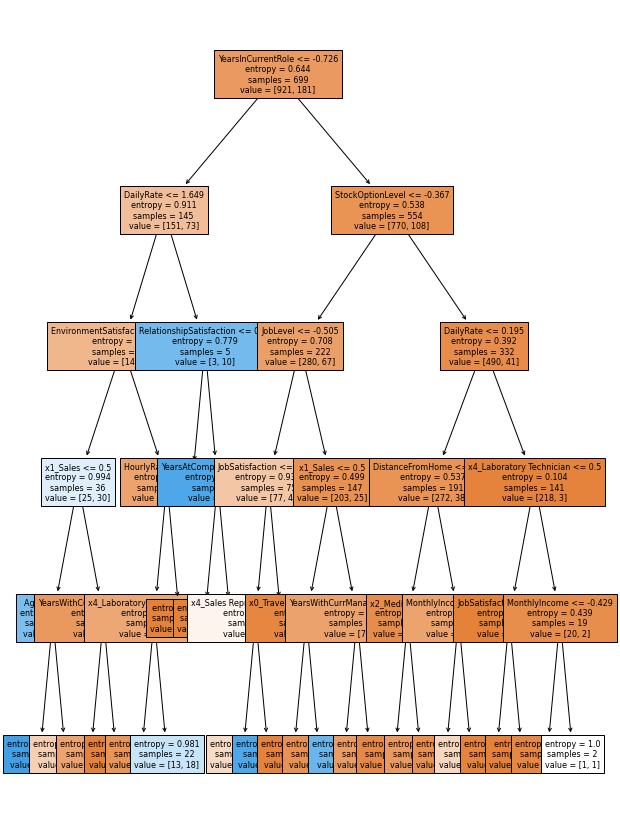

In [178]:
from sklearn import config_context, tree
cat_names = randomforest_grid_search.best_estimator_.named_steps['preproc'].transformers_[0][1].named_steps['onehot_cat'].get_feature_names_out()
num_names = randomforest_grid_search.best_estimator_.named_steps['preproc'].transformers_[1][2]
vip = randomforest_grid_search.best_estimator_.steps[1]
vip = vip[1].estimators_

plt.figure(figsize=(10, 15)) 
tree.plot_tree(vip[0], feature_names=np.hstack([cat_names, num_names]), fontsize=8, filled=True)
plt.show()

### Gradient Boosting Classifier

In [179]:
gradientboosting_grid_search.classes_

array(['No', 'Yes'], dtype=object)

In [180]:
vip = gradientboosting_grid_search.best_estimator_['mdl']
vip

GradientBoostingClassifier(learning_rate=0.625, max_depth=10)

## Performance metrics on test data


Here, we can see the performance of the model, which is pretty nice! We can also look into different scores specifically for more insight into the performance.

### Logistic Regression Classifier

In [181]:
# TODO: print your classification report of your model
print(classification_report(y_test, logisticregression_grid_search.best_estimator_.predict(X_test)))



              precision    recall  f1-score   support

          No       0.89      0.98      0.94       309
         Yes       0.82      0.39      0.53        59

    accuracy                           0.89       368
   macro avg       0.86      0.69      0.73       368
weighted avg       0.88      0.89      0.87       368



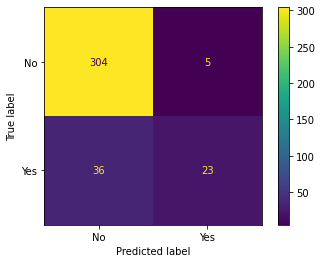

In [185]:
# TODO: plot the confusion matrix graph
# show the confusion matrix which shows true positive rate, true negative rate, false positive rate and false negative rate 
logisticregression_cm = confusion_matrix(y_test, logisticregression_grid_search.best_estimator_.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=logisticregression_cm,
                               display_labels=logisticregression_grid_search.classes_)
disp.plot()

plt.show()

### Random Forest Classifier

              precision    recall  f1-score   support

          No       0.85      0.99      0.91       309
         Yes       0.60      0.10      0.17        59

    accuracy                           0.85       368
   macro avg       0.73      0.54      0.54       368
weighted avg       0.81      0.85      0.80       368



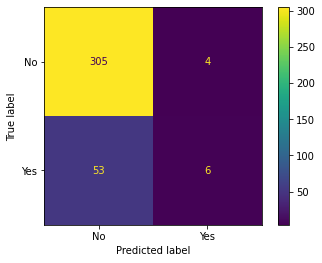

In [186]:
# TODO: print your classification report of your model
print(classification_report(y_test, randomforest_grid_search.best_estimator_.predict(X_test)))
# TODO: plot the confusion matrix graph
# show the confusion matrix which shows true positive rate, true negative rate, false positive rate and false negative rate 
randomforest_cm = confusion_matrix(y_test, randomforest_grid_search.best_estimator_.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=randomforest_cm,
                               display_labels=randomforest_grid_search.classes_)
disp.plot()

plt.show()


### Gradient Boosting Classifier

              precision    recall  f1-score   support

          No       0.89      0.95      0.92       309
         Yes       0.58      0.36      0.44        59

    accuracy                           0.86       368
   macro avg       0.73      0.65      0.68       368
weighted avg       0.84      0.86      0.84       368



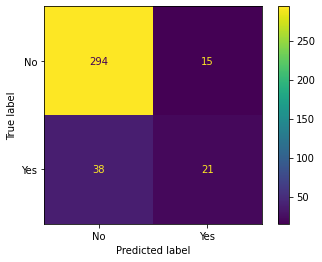

In [188]:
# TODO: print your classification report of your model
print(classification_report(y_test, gradientboosting_grid_search.best_estimator_.predict(X_test)))

# TODO: plot the confusion matrix graph
# show the confusion matrix which shows true positive rate, true negative rate, false positive rate and false negative rate 
gradientboosting_cm = confusion_matrix(y_test, gradientboosting_grid_search.best_estimator_.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=gradientboosting_cm,
                               display_labels=gradientboosting_grid_search.classes_)
disp.plot()

plt.show()

## Calculate the Financial Value of the Models
Note: We are labeling Leave as True and Stay as False
* Cost of replacing an employee is \$120,000 (RC)
* Cost of intervention \$2,000 used on each employee predicted to leave (IC)
* Intervention success rate is 20% (SR)

In [192]:
# true positive (correct Leave prediction) benefit
# if you correctly predict that someone is leaving, and you intervene, that has a 20% success rate
# which means the benefit of correctly predicting leave is the -(cost of intervention minus) - (20% of the cost of replacing an employee)
# we could really keep the true positive at 0 and make the true negative represent the inverse of the above equation
# which would be -1 * -2000 - (120000 * .2)) = 2000 - 120000 * .2 
true_positive_cb = 0
# true negative (correct Stay prediction) benefit 
# the benefit of predicting stay correctly
true_negative_cb = 2000 - 120000 * .2

# false positive (incorrectly predict Leave) cost
# cost of intervention used on each employee predicted to leave
false_positive_cb = 2000 

# false negative (incorrectly predict Stay) cost
# if you predict that someone will stay and they leave, that leaves you with cost of replacing employee
false_negative_cb = 120000 

cost_benefits = [
                [true_positive_cb, false_positive_cb],
                [false_negative_cb, true_negative_cb]
]

# use the confusion matrices for each of the models multiplied by the 
# cost benefits matrix to determine the models' respective financial values
# get the sum of each product matrix to determine total financial value
model_financial_values = {
    'logistic_regression': np.multiply(
    logisticregression_cm,
    cost_benefits
).sum()
, 
    'random_forest':np.multiply(
    randomforest_cm,
    cost_benefits
).sum(),
    'gradient_boosting': np.multiply(
    gradientboosting_cm,
    cost_benefits
).sum()
}

for key, val in model_financial_values.items():
  print(f'The financial value of the {key} model is ${val}\n')

print(f'The model with the greatest financial value is {max(model_financial_values, key=model_financial_values.get)}\n')
print(f'The model with the least financial value is {min(model_financial_values,key=model_financial_values.get)}')


The financial value of the logistic_regression model is $3824000.0

The financial value of the random_forest model is $6236000.0

The financial value of the gradient_boosting model is $4128000.0

The model with the greatest financial value is random_forest

The model with the least financial value is logistic_regression
